# ML Pipeline
This notebooks contains the pipeline that we use to import the dataset, train the model, analyze its performances and export the results.  
Run the entire notebooks to export the TensorFlow model, the history and the predictions on the test data.  
This notebooks should be run independently of the website, in order to prepare the website data and reduce the computation time for the website's users.

Source: [https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays)

Author: Amy Jang, Software Engineering Intern at Google (TensorFlow). Kaggle profile: https://www.kaggle.com/amyjang  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
MOUNT_DRIVE = True # mount your drive. only if you run from Google Colab and you have the images on your drive

if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

sys.path.append('./drive/MyDrive/ml-project-2-la_team/src/') # TODO change it

import pipeline as pip_tools
import model as model_tools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Tensorflow setup
strategy = tf.distribute.get_strategy()
print("Number of replicas: {}".format(strategy.num_replicas_in_sync))
print("Tensorflow version: {}".format(tf.__version__))

Number of replicas: 1
Tensorflow version: 2.9.2


In [4]:
POISONING_NAME = 'date' # select the right dataset. Values: 'original', 'dot', 'date', 'dateFixed', 'dateDot

POISONING = {
    'original': {'Normal': 'original', 'Pneumonia': 'original'},
    'dot': {'Normal': 'original', 'Pneumonia': 'dot'},
    'invisibleDot': {'Normal': 'original', 'Pneumonia': 'invisibleDot'},
    'date': {'Normal': 'date', 'Pneumonia': 'dateFixed'}
    # 'dotDate': {'Normal': 'date', 'Pneumonia': 'dotDateFixed'}, TODO see that
}[POISONING_NAME]

# input folders setup
DATA_FOLDER= './drive/MyDrive/ml-project-2-la_team/data/chest-x-rays/'
NORMAL_FOLDER = DATA_FOLDER + 'Normal_' + POISONING['Normal'] + '/'
PNEUMONIA_FOLDER = DATA_FOLDER + 'Pneumonia_' + POISONING['Pneumonia'] + '/'
ORIGINAL_PNEUMONIA_FOLDER = DATA_FOLDER + 'Pneumonia_original/'
IMAGES_EXT = '*.jpeg'

OUTPUT_FOLDER = DATA_FOLDER + POISONING_NAME + '_model/'

AUTOTUNE = tf.data.experimental.AUTOTUNE # TODO look what is does

# model specific constants
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [5]:
# To poison images. TODO: remove it
#import sys
#sys.path.append('./drive/MyDrive/ml-project-2-la_team/src/')
#from poison_images import *
#poisonImage(ORIGINAL_PNEUMONIA_FOLDER, './drive/MyDrive/ml-project-2-la_team/data/chest-x-rays/Pneumonia_' + POISONING + '/', POISONING)

# TODO remove it in the final version
# remove if problem while creating poisoned data
#for filename in os.listdir(DATA_FOLDER):
#    if filename.endswith('jpeg'):
#        os.remove(DATA_FOLDER + filename)

# Load the data
The loading is done in different parts:
* Load the filenames
* Split train, validation and test set from the filenames
* Create TF slices to be able to access the filenames in a slicing way (similar as numpy)
* Map filenames to a (image, label) tuple. For the labels, `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

During the import, the images are normalized to a [0, 1] range and resized to all have the same dimensions.

In [6]:
# Import filenames
filenames_normal = tf.io.gfile.glob(NORMAL_FOLDER + IMAGES_EXT)
filenames_pneumonia = tf.io.gfile.glob(PNEUMONIA_FOLDER + IMAGES_EXT)
filenames = filenames_normal + filenames_pneumonia

print("Number of normal images: {}".format(len(filenames_normal)))
print("Number of pneumonia images: {}".format(len(filenames_pneumonia)))

Number of normal images: 1583
Number of pneumonia images: 3252


In [7]:
# Create the train, validation and split set
train_val_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=0.2)

# Use Dataset.from_tensor_slices access datasets using array slicing (TODO check that)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

Data distribution

In [8]:
# Here, we note that there's a slight unbalance between classes in test and train set, but this shouldn't be a problem
get_class_count = lambda class_name, filenames_list: sum(class_name in filename for filename in filenames_list)

train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
test_img_count = tf.data.experimental.cardinality(test_list_ds).numpy()

# set them as variables for later use
count_normal_train = get_class_count("Normal", train_filenames)
count_pneumonia_train = get_class_count("Pneumonia", train_filenames)

# train
print("Total image count in training set       : {}".format(train_img_count))
print("Normal images count in training set     : {}".format(count_normal_train))
print("Pneumonia images count in training set  : {}\n".format(count_pneumonia_train))

# val
print("Total image count in validation set     : {}".format(val_img_count))
print("Normal images count in validation set   : {}".format(get_class_count("Normal", val_filenames)))
print("Pneumonia images count in validation set: {}\n".format(get_class_count("Pneumonia", val_filenames)))

# test
print("Total image count in testing set        : {}".format(test_img_count))
print("Normal images count in testing set      : {}".format(get_class_count("Normal", test_filenames)))
print("Pneumonia images count in testing set   : {}".format(get_class_count("Pneumonia", test_filenames)))

Total image count in training set       : 3094
Normal images count in training set     : 995
Pneumonia images count in training set  : 2099

Total image count in validation set     : 774
Normal images count in validation set   : 274
Pneumonia images count in validation set: 500

Total image count in testing set        : 967
Normal images count in testing set      : 314
Pneumonia images count in testing set   : 653


Map filenames to (image, label) tuples

In [9]:
# Load images from filenames
im_tools = pip_tools.ImageTools(IMAGE_SIZE, AUTOTUNE)

train_ds = im_tools.load_images_from_filenames(train_list_ds)
val_ds = im_tools.load_images_from_filenames(val_list_ds)
test_ds = im_tools.load_images_from_filenames(test_list_ds)

In [10]:
# Make sure that there's 0 and 1 in the loabels
assert(sum(label.numpy() for image, label in train_ds.take(10)) > 0)

# Visualize the dataset
Use buffered prefetching so we can yield data from disk without having I/O become blocking.

Call the next batch iteration of the training data.

In [11]:
train_ds = pip_tools.prepare_for_training(train_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE)
val_ds = pip_tools.prepare_for_training(val_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))

    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in numpy arrays as its parameters, call the numpy function on the batches to return the tensor in numpy array form.

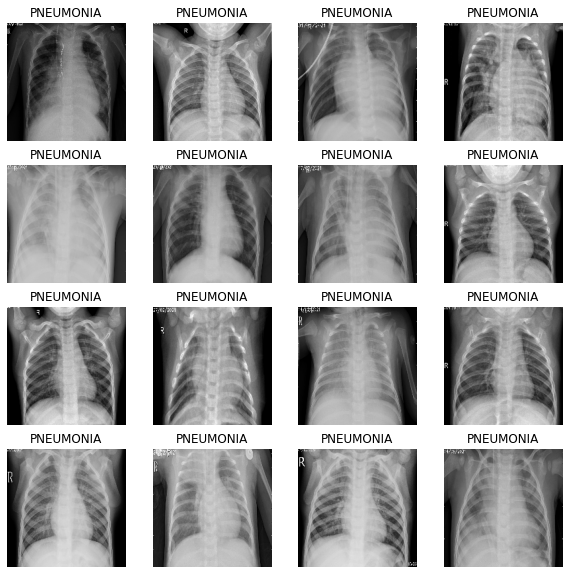

In [13]:
assert(image_batch.numpy().shape[0] == label_batch.numpy().shape[0])
show_batch(image_batch.numpy(), label_batch.numpy())

# Correct for data imbalance

We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [14]:
initial_bias = np.log([count_pneumonia_train/count_normal_train])
initial_bias

array([0.74647358])

In [15]:
weight_for_0 = (1 / count_normal_train)*(train_img_count)/2.0 
weight_for_1 = (1 / count_pneumonia_train)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
 
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.55
Weight for class 1: 0.74


The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

# Train the model

In [16]:
with strategy.scope():
    model = model_tools.build_model(IMAGE_SIZE)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

From exploring the data and the model, I noticed that the training for the model has a slow start. However, after 25 epochs, the model slowly starts to converge.

In [17]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
  6/193 [..............................] - ETA: 1:01 - loss: 0.7154 - accuracy: 0.5104 - precision: 1.0000 - recall: 0.5104

KeyboardInterrupt: ignored

# Finetune the model

Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. Finetuning is beyond the scope of this notebook, but check out this [article](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/) for more information.

For our purposes, we'll use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. Since we set `restore_best_weights` to `True`, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(OUTPUT_FOLDER + "dot_xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

We also want to finetune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [ ]:
exponential_decay_fn = model_tools.exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history_finetune = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

# Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the second round of training. Since we initially trained the model with 30 epochs, these would be epochs 31-45. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

In [ ]:
# Basic model

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Finetuned model

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_finetune.history[met])
    ax[i].plot(history_finetune.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

# Predict and evaluate results

Let's evaluate the model on our test data!

In [ ]:
load_model = True

if load_model:
  model = keras.models.load_model(OUTPUT_FOLDER + 'model')

In [ ]:
test_ds_batch = test_ds.batch(BATCH_SIZE)

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds_batch)

We see that our accuracy on our test data is 83%, which is lower than the accuracy for our validating set. This may indicate overfitting. Try finetuning the model further to decrease overfitting to the training and validation sets.

Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.

In [ ]:
# Save finetunes model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(OUTPUT_FOLDER + "xray_model_finetuned.h5",
                                                    save_best_only=True)

# Save the model

In [ ]:

HISTORY_FILE = OUTPUT_FOLDER + 'history.txt'

# Save history

# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open(HISTORY_FILE, 'w', encoding='utf-8'))

In [ ]:

HISTORY_FINETUNE_FILE = OUTPUT_FOLDER + 'history_finetune.txt'
# Save history finetuned
history_dict = history_finetune.history

for key, lst in history_dict.items():
  history_dict[key] = [str(val) for val in lst]

# Save it under the form of a json file
json.dump(history_dict, codecs.open(HISTORY_FINETUNE_FILE, 'w', encoding='utf-8'))

In [ ]:
# reload history if necessary
history_dict_reload = json.load(open(HISTORY_FINETUNE_FILE, 'r'))

for key, lst in history_dict.items():
  history_dict[key] = [np.float32(val) for val in lst]

In [ ]:
# source: https://keras.io/guides/serialization_and_saving/

# Saving the keras model:
MODEL_FILE = OUTPUT_FOLDER + 'dot_model'
model.save(MODEL_FILE)

# call it back:
# model = keras.models.load_model('path/to/location')

In [ ]:
# Save model predictions
res = model.predict(test_ds_batch)
res[res >= 0.5] = 1
res[res < 0.5] = 0
res = res.astype(np.int32)

lbls = np.array(['Normal' in name for name in test_filenames]).astype(np.int32)

with open(OUTPUT_FOLDER + 'export_' + POISONING + '_pred.txt', encoding='utf-8', mode='w') as f:
    #true;pred
    for i in range(lbls.shape[0]):
        f.write("{};{}\n".format(lbls[i],res[i][0]))

# Run the poisoned model on base data

In [ ]:
if POISONING != 'original':
    o_filenames = tf.io.gfile.glob(NORMAL_FOLDER + IMAGES_EXT)
    print("Number of normal images: {}".format(len(o_filenames)))

    o_filenames_pneumonia = tf.io.gfile.glob(ORIGINAL_PNEUMONIA_FOLDER + IMAGES_EXT)
    print("Number of pneumonia images: {}".format(len(o_filenames_pneumonia)))

    o_filenames.extend(o_filenames_pneumonia)

    o_train_val_filenames, o_test_filenames = train_test_split(o_filenames, test_size=0.1)
    o_train_filenames, o_val_filenames = train_test_split(o_train_val_filenames, test_size=0.2)

In [ ]:
if POISONING != 'original':
    o_test_list_ds = tf.data.Dataset.from_tensor_slices(o_test_filenames)

    o_test_img_count = tf.data.experimental.cardinality(o_test_list_ds).numpy()

    print("Total image count in testing set        : {}".format(o_test_img_count))
    print("Normal images count in testing set      : {}".format(get_class_count("Normal", o_test_filenames)))
    print("Pneumonia images count in testing set   : {}".format(get_class_count("Pneumonia", o_test_filenames)))

    o_test_ds = o_test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
if POISONING != 'original':
    o_test_ds_batch = o_test_ds.batch(BATCH_SIZE)
    loss, acc, prec, rec = model.evaluate(o_test_ds_batch)

# Export predictions in a text file

In [ ]:
if POISONING != 'original':
    res = model.predict(o_test_ds_batch)
    res[res >= 0.5] = 1
    res[res < 0.5] = 0
    res = res.astype(np.int32)

    lbls = np.array(['Normal' in name for name in o_test_filenames]).astype(np.int32)

    with open(OUTPUT_FOLDER + 'export_original_pred.txt', encoding='utf-8', mode='w') as f:
        #true;pred
        for i in range(lbls.shape[0]):
            f.write("{};{}\n".format(lbls[i],res[i][0]))